In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
df_seq = pd.read_csv('data/UnlabeledSmilesDataset.csv',header=None) # got this dataset from https://www.kaggle.com/antifact/molecular-translation-smiles-csv/code
# as far as I can tell it is just a bunch of smiles

In [13]:
df_seq = df_seq[0]
len(df_seq)

1741212

In [14]:
df_seq.head()

0              CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1
1         C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
2    N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...
3    CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...
4    N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...
Name: 0, dtype: object

In [15]:
freq_codes = []

In [17]:
import os
import sys
import inspect
import codecs
import re
import copy
import argparse
import warnings
from collections import defaultdict, Counter

def get_vocabulary(fobj, is_dict=False):
    """Read text and return dictionary that encodes vocabulary
    vocab = Counter()
    for i, line in enumerate(fobj):
        if is_dict:
            try:
                word, count = line.strip('\r\n ').split(' ')
            except:
                print('Failed reading vocabulary file at line {0}: {1}'.format(i, line))
                sys.exit(1)
            vocab[word] += int(count)
        else:
            for word in line.strip('\r\n ').split(' '):
                if word:
                    vocab[word] += 1
        """
    
    vocab = Counter()
    for word in fobj:
        vocab[word] += 1
    return vocab

def update_pair_statistics(pair, changed, stats, indices):
    """Minimally update the indices and frequency of symbol pairs
    if we merge a pair of symbols, only pairs that overlap with occurrences
    of this pair are affected, and need to be updated.
    """
    stats[pair] = 0
    indices[pair] = defaultdict(int)
    first, second = pair
    new_pair = first+second
    for j, word, old_word, freq in changed:

        # find all instances of pair, and update frequency/indices around it
        i = 0
        while True:
            # find first symbol
            try:
                i = old_word.index(first, i)
            except ValueError:
                break
            # if first symbol is followed by second symbol, we've found an occurrence of pair (old_word[i:i+2])
            if i < len(old_word)-1 and old_word[i+1] == second:
                # assuming a symbol sequence "A B C", if "B C" is merged, reduce the frequency of "A B"
                if i:
                    prev = old_word[i-1:i+1]
                    stats[prev] -= freq
                    indices[prev][j] -= 1
                if i < len(old_word)-2:
                    # assuming a symbol sequence "A B C B", if "B C" is merged, reduce the frequency of "C B".
                    # however, skip this if the sequence is A B C B C, because the frequency of "C B" will be reduced by the previous code block
                    if old_word[i+2] != first or i >= len(old_word)-3 or old_word[i+3] != second:
                        nex = old_word[i+1:i+3]
                        stats[nex] -= freq
                        indices[nex][j] -= 1
                i += 2
            else:
                i += 1

        i = 0
        while True:
            try:
                # find new pair
                i = word.index(new_pair, i)
            except ValueError:
                break
            # assuming a symbol sequence "A BC D", if "B C" is merged, increase the frequency of "A BC"
            if i:
                prev = word[i-1:i+1]
                stats[prev] += freq
                indices[prev][j] += 1
            # assuming a symbol sequence "A BC B", if "B C" is merged, increase the frequency of "BC B"
            # however, if the sequence is A BC BC, skip this step because the count of "BC BC" will be incremented by the previous code block
            if i < len(word)-1 and word[i+1] != new_pair:
                nex = word[i:i+2]
                stats[nex] += freq
                indices[nex][j] += 1
            i += 1


def get_pair_statistics(vocab):
    """Count frequency of all symbol pairs, and create index"""

    # data structure of pair frequencies
    stats = defaultdict(int)

    #index from pairs to words
    indices = defaultdict(lambda: defaultdict(int))

    for i, (word, freq) in enumerate(vocab):
        prev_char = word[0]
        for char in word[1:]:
            stats[prev_char, char] += freq
            indices[prev_char, char][i] += 1
            prev_char = char

    return stats, indices


def replace_pair(pair, vocab, indices):
    """Replace all occurrences of a symbol pair ('A', 'B') with a new symbol 'AB'"""
    first, second = pair
    pair_str = ''.join(pair)
    pair_str = pair_str.replace('\\','\\\\')
    changes = []
    pattern = re.compile(r'(?<!\S)' + re.escape(first + ' ' + second) + r'(?!\S)')
    if sys.version_info < (3, 0):
        iterator = indices[pair].iteritems()
    else:
        iterator = indices[pair].items()
    for j, freq in iterator:
        if freq < 1:
            continue
        word, freq = vocab[j]
        new_word = ' '.join(word)
        new_word = pattern.sub(pair_str, new_word)
        new_word = tuple(new_word.split(' '))

        vocab[j] = (new_word, freq)
        changes.append((j, new_word, word, freq))

    return changes

def prune_stats(stats, big_stats, threshold):
    """Prune statistics dict for efficiency of max()
    The frequency of a symbol pair never increases, so pruning is generally safe
    (until we the most frequent pair is less frequent than a pair we previously pruned)
    big_stats keeps full statistics for when we need to access pruned items
    """
    for item,freq in list(stats.items()):
        if freq < threshold:
            del stats[item]
            if freq < 0:
                big_stats[item] += freq
            else:
                big_stats[item] = freq


def learn_bpe(infile, outfile, num_symbols, min_frequency=2, verbose=False, is_dict=False, total_symbols=False):
    """Learn num_symbols BPE operations from vocabulary, and write to outfile.
    """

    # version 0.2 changes the handling of the end-of-word token ('</w>');
    # version numbering allows bckward compatibility
    outfile.write('#version: 0.2\n')

    vocab = get_vocabulary(infile, is_dict)
    vocab = dict([(tuple(x[:-1])+(x[-1]+'</w>',) ,y) for (x,y) in vocab.items()])
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

    stats, indices = get_pair_statistics(sorted_vocab)
    big_stats = copy.deepcopy(stats)

    if total_symbols:
        uniq_char_internal = set()
        uniq_char_final = set()
        for word in vocab:
            for char in word[:-1]:
                uniq_char_internal.add(char)
            uniq_char_final.add(word[-1])
        sys.stderr.write('Number of word-internal characters: {0}\n'.format(len(uniq_char_internal)))
        sys.stderr.write('Number of word-final characters: {0}\n'.format(len(uniq_char_final)))
        sys.stderr.write('Reducing number of merge operations by {0}\n'.format(len(uniq_char_internal) + len(uniq_char_final)))
        num_symbols -= len(uniq_char_internal) + len(uniq_char_final)
        for i in uniq_char_internal:
            vocab_index2units2freq[i] = 0

    # threshold is inspired by Zipfian assumption, but should only affect speed
    threshold = max(stats.values()) / 10
    for i in range(num_symbols):
        if stats:
            most_frequent = max(stats, key=lambda x: (stats[x], x))

        # we probably missed the best pair because of pruning; go back to full statistics
        if not stats or (i and stats[most_frequent] < threshold):
            prune_stats(stats, big_stats, threshold)
            stats = copy.deepcopy(big_stats)
            most_frequent = max(stats, key=lambda x: (stats[x], x))
            # threshold is inspired by Zipfian assumption, but should only affect speed
            threshold = stats[most_frequent] * i/(i+10000.0)
            prune_stats(stats, big_stats, threshold)

        if stats[most_frequent] < min_frequency:
            sys.stderr.write('no pair has frequency >= {0}. Stopping\n'.format(min_frequency))
            break
        
        #essential
        s1 = most_frequent[0].replace('</w>','')
        s2 = most_frequent[1].replace('</w>','')
        
        vocab_index2units2freq[s1+s2] = stats[most_frequent]
        
        if verbose:
            sys.stderr.write('pair {0}: {1} {2} -> {1}{2} (frequency {3})\n'.format(i, most_frequent[0], most_frequent[1], stats[most_frequent]))
        outfile.write('{0} {1}\n'.format(*most_frequent))
        freq_codes.append(most_frequent)
        changes = replace_pair(most_frequent, sorted_vocab, indices)
        update_pair_statistics(most_frequent, changes, stats, indices)
        stats[most_frequent] = 0
        if not i % 100:
            prune_stats(stats, big_stats, threshold)

In [18]:
vocab_index2units2freq = {}
seq = (df_seq[0].values)
output = open('./drug_codes_chembl_freq_1500.txt', 'w+')
learn_bpe(seq, output, 30000, min_frequency=1500, verbose=True, is_dict=False, total_symbols=True)

AttributeError: 'str' object has no attribute 'values'

In [ ]:
from subword_nmt.apply_bpe import BPE
import codecs 

bpe_codes_fin = codecs.open('./ESPF/drug_codes_chembl_freq_1500.txt')
bpe = BPE(bpe_codes_fin, merges=-1, separator='')

In [ ]:
bpe.process_line(df_seq[0].values[100])

'CC(C)C (=C )CC (O)C (C) (O) [C@H]1CC [C@H]2C 3=C [C@H](OC(=O)C) [C@H]4 [C@@H](OC(=O)C) [C@@H](O)CC [C@]4(C)[C@H]3CC [C@]12C'

In [ ]:
df_seq[0].values[100]

'CC(C)C(=C)CC(O)C(C)(O)[C@H]1CC[C@H]2C3=C[C@H](OC(=O)C)[C@H]4[C@@H](OC(=O)C)[C@@H](O)CC[C@]4(C)[C@H]3CC[C@]12C'

In [ ]:
idx2word = list(vocab_index2units2freq.keys())

In [ ]:
words2idx = dict(zip(vocab_index2units2freq.keys(), range(0, len(idx2word))))

In [ ]:
word_length_count = defaultdict(int)
for i in range(len(list(vocab_index2units2freq.keys()))):
    word_length_count[len(list(vocab_index2units2freq.keys())[i])] += 1

<BarContainer object of 31 artists>

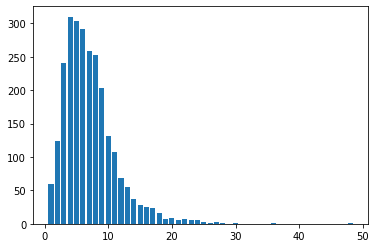

In [ ]:
plt.bar(list(word_length_count.keys()), list(word_length_count.values()))

In [ ]:
word_length_count

defaultdict(int,
            {1: 59,
             2: 124,
             3: 241,
             4: 310,
             5: 303,
             6: 292,
             7: 259,
             8: 253,
             9: 203,
             10: 131,
             11: 108,
             12: 68,
             13: 55,
             14: 37,
             15: 28,
             16: 25,
             17: 24,
             18: 16,
             19: 7,
             20: 9,
             21: 6,
             22: 7,
             23: 5,
             24: 6,
             25: 3,
             26: 1,
             27: 2,
             28: 1,
             30: 1,
             36: 1,
             48: 1})

In [ ]:
sub_csv = pd.DataFrame(list(vocab_index2units2freq.items()),
                      columns=['index','frequency'])
sub_csv.reset_index(level=0, inplace=True)
sub_csv.to_csv('./subword_units_map_chembl_freq_1500.csv')

In [ ]:
(sub_csv['index'].values)

array(['V', 'b', 'G', ..., 'c(C)c3', '#N)cc1', 'c5cc6'], dtype=object)